In [65]:
#loading all the libraries we will be using.
import numpy as np #We will make extensive use of Numpy arrays 
import multiprocessing as mp #Enable multiprocessing
from astropy import units as u
from astropy.coordinates import Angle
from astropy.io import fits
import math #needed to check for NaNs

import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting of os/x
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images
import time as t
%matplotlib inline

import neossatlib as neo

#for PCA analysis 
import scipy.linalg.lapack as la
import scipy.optimize as op
    
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry

In [66]:
workdir='Borisov/'                #Directory that contains cleaned FITS files (don't forget the trailing '/')
fileslist='files_clean_1.list'     #Simple text file that contains the names of all the FITS files to process.   
bpix=-1.0e10                   #value to mark bad pixels. Any pixel *below* bpix is considered invalid.
sigscalel=1.0                  #low bounds for display clipping.  Keep small to keep background 'dark'
sigscaleh=1.0                  #high bounds for display clipping.
nprocessor=24                  #Number of processors to use for data processing. 
#--- Parameters for photometry ---#
zmag=21.46                      #zero-point for instrumental magnitude (selected by eye, don't trust my value)
photap=4                 #photometric aperture

#Should get this from Header, but here's the values for NEOSSat 
gain=1.1 #e/ADU
readnoise=8 #e/pixel
imagefiles=neo.read_file_list(fileslist)

In [67]:
lightlist_in=[]
jddate=[]
exptime=[]
ra =[]
dec=[]
rol=[]
nfiles=len(imagefiles)



for i in range(nfiles):
    filename=workdir+imagefiles[i]
    hdulist = fits.open(filename)
    shutter=hdulist[0].header['SHUTTER']
    mode=hdulist[0].header['MODE']
    if (int(shutter[0]) == 0) & (int(mode[0:2]) == 16):  #Check if shutter was open or closed.
        lightlist_in.append(imagefiles[i])
        jddate.append(float(hdulist[0].header['JD-OBS']))
        temp_ra = hdulist[0].header['OBJCTRA']
        ra.append(Angle(temp_ra+' hours').degree)
        temp_dec = hdulist[0].header['OBJCTDEC']
        dec.append(Angle(temp_ra+' hours').degree)
        rol.append(float(hdulist[0].header['OBJCTROL']))
        exptime.append(float(hdulist[0].header['EXPOSURE']))
        
    hdulist.close()

jddate=np.array(jddate)
exptime=np.array(exptime)
print("number of images: ",len(lightlist_in))
print(ra, dec, rol)

number of images:  12
[149.95583333333332, 149.95624999999998, 149.95624999999998, 149.9525, 149.95583333333332, 149.95624999999998, 149.95624999999998, 149.95583333333332, 149.95583333333332, 149.95624999999998, 149.95583333333332, 149.95583333333332] [149.95583333333332, 149.95624999999998, 149.95624999999998, 149.9525, 149.95583333333332, 149.95624999999998, 149.95624999999998, 149.95583333333332, 149.95583333333332, 149.95624999999998, 149.95583333333332, 149.95583333333332] [94.86506, 94.86667, 94.86342, 94.81367, 94.86463, 94.86753, 94.8593, 94.86449, 94.86107, 94.86295, 94.85461, 94.85593]


In [68]:
idx=np.argsort(jddate)
jddate=jddate[idx]
exptime=exptime[idx]
lightlist=[]
for i in idx:
    lightlist.append(lightlist_in[i])
    
photometry_data = {}
no_stars = []

NEOS_SCI_2019292034200_clean.fits


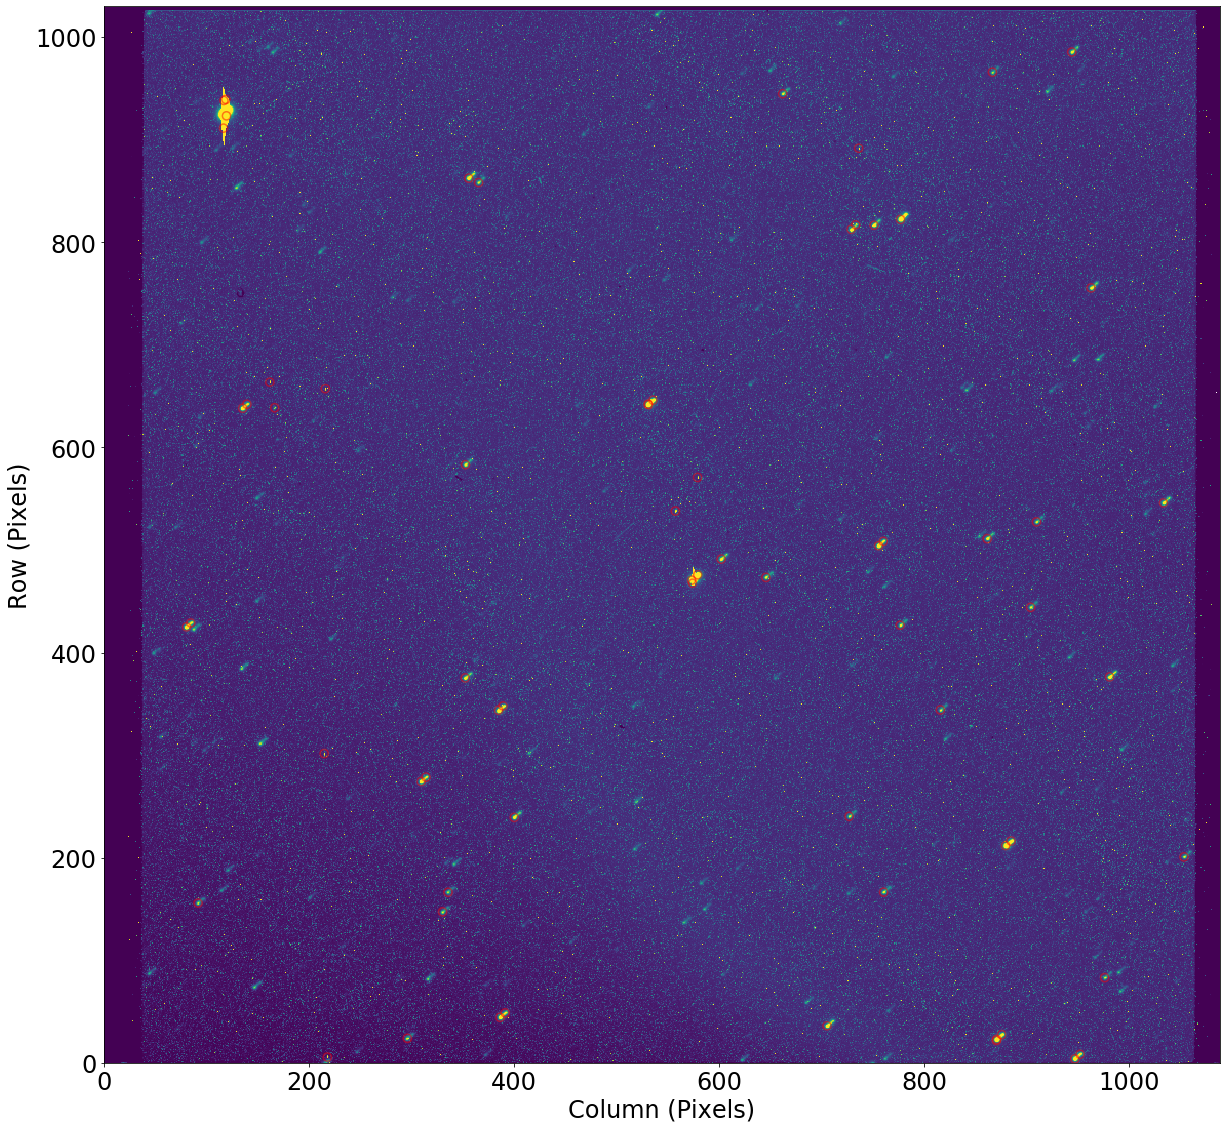

NEOS_SCI_2019292034200_clean.fits


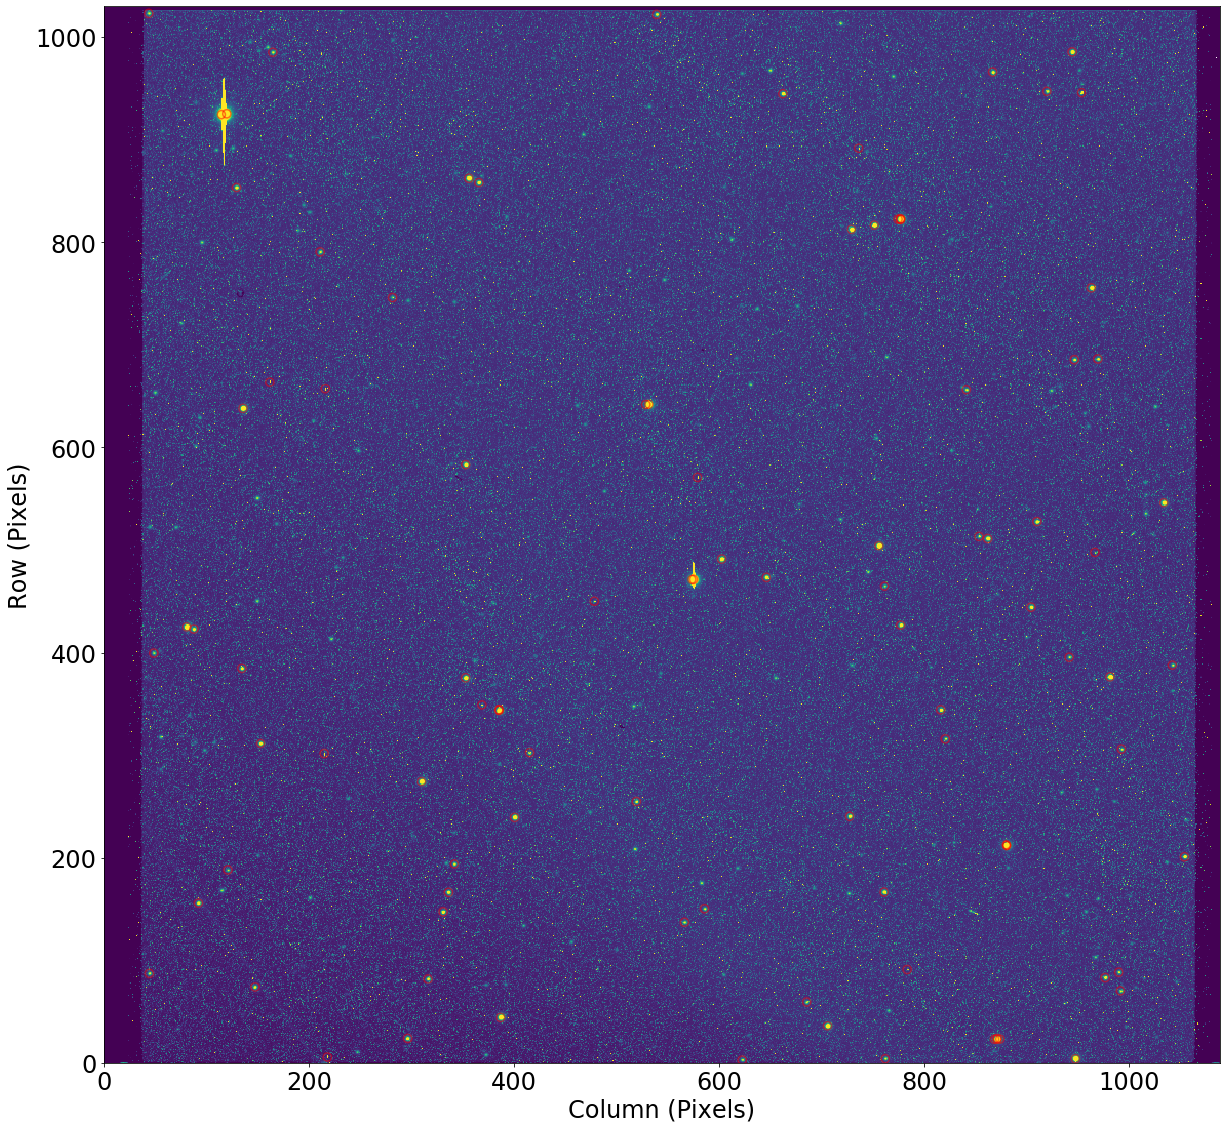

In [90]:
for i in range(2):
    filename=workdir+lightlist[i]

    print(lightlist[0])

    scidata=neo.read_fitsdata(filename)
    imstat=neo.imagestat(scidata,bpix)

    mean, median, std = sigma_clipped_stats(scidata, sigma=3.0, maxiters=5)
    daofind = DAOStarFinder(fwhm=2.0, threshold=35*std)
    sources = daofind(scidata - median)

    neo.plot_image_wsource(scidata,imstat,3.0,50.0,sources)

    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = CircularAperture(positions, r=photap)
    phot_table = aperture_photometry(scidata-median, apertures)

    nstar=len(phot_table['aperture_sum'])

    for j in range(nstar):
        photometry_data[i,j] = [phot_table['xcenter'][j], phot_table['ycenter'][j]]
        temp_sum = j
    no_stars.append(temp_sum)

In [91]:
print(no_stars)

[67, 99, 67, 99, 67, 99]


In [92]:
photometry_data

{(0, 0): [<Quantity 946.78467377 pix>, <Quantity 3.8451861 pix>],
 (0, 1): [<Quantity 218.02035897 pix>, <Quantity 5.57335163 pix>],
 (0, 2): [<Quantity 951.78624909 pix>, <Quantity 8.30508495 pix>],
 (0, 3): [<Quantity 870.20672599 pix>, <Quantity 21.66423604 pix>],
 (0, 4): [<Quantity 870.65976418 pix>, <Quantity 22.83012862 pix>],
 (0, 5): [<Quantity 296.02493917 pix>, <Quantity 23.86870329 pix>],
 (0, 6): [<Quantity 875.39227504 pix>, <Quantity 27.46806294 pix>],
 (0, 7): [<Quantity 705.17604814 pix>, <Quantity 36.10466187 pix>],
 (0, 8): [<Quantity 386.40607841 pix>, <Quantity 44.40372158 pix>],
 (0, 9): [<Quantity 391.37800665 pix>, <Quantity 48.70320725 pix>],
 (0, 10): [<Quantity 975.83117924 pix>, <Quantity 83.05754087 pix>],
 (0, 11): [<Quantity 330.33874347 pix>, <Quantity 147.14946484 pix>],
 (0, 12): [<Quantity 91.97860915 pix>, <Quantity 155.71237098 pix>],
 (0, 13): [<Quantity 335.62756515 pix>, <Quantity 166.25954736 pix>],
 (0, 14): [<Quantity 760.34530925 pix>, <Quant

In [93]:
#[img num, star num]
photometry_data[0, 56]

[<Quantity 733.12471718 pix>, <Quantity 816.92555771 pix>]

In [166]:
# compare only two imgs
img1 = []
img2 = []
for key in photometry_data.keys():
    if key[0] == 0:
        img1.append([key[1], photometry_data[key][0], photometry_data[key][1]])
    if key[0] == 1:
        img2.append([key[1], photometry_data[key][0], photometry_data[key][1]])
        
#So: [star num, x pos, y pos]

In [189]:
#Nearest neighbour algorithm
if len(img1) > len(img2):    # img1 is the shorter array
    img1, img2 = img2, img1  # ohh yeah big brain time in place swap

neighbors = []
    
for star1 in img1:    # use img1 as reference list
    dist = 2000 * u.pix  # arbitrary initial val
    closest_star = None
    for star2 in img2:
        # calc distance
        dx = star1[1] - star2[1]
        dy = star1[2] - star2[2]
        rel_dist = (dx**2 + dy**2)**0.5
        # get smallest dist - it's big brain time now
        if rel_dist < dist:
            closest_star = star2
            dist = rel_dist
    # pair the lucky couple
    neighbors.append([star1, closest_star, dist])

In [191]:
neighbors[0]

[[0, <Quantity 946.78467377 pix>, <Quantity 3.8451861 pix>],
 [2, <Quantity 947.27826983 pix>, <Quantity 3.96730481 pix>],
 <Quantity 0.50847817 pix>]